# 4.1 MCMC

## Objectives

+ Intro: Bayesian Analysis
+ Markov Chain analysis and Monte Carlo Markov chain(MCMC) 
+ MCMC methods: Metropolis-Hastings, Gibbs Sampling


### List of Symbols :
$--\mu$ is the mean<br>
$-- \sigma^2$ is the variance<br>
$-- y_i$ represents the height of a person $i$<br>
$--\large\epsilon_i$ is the individual error term<br>
$--\ $X is the set of states<br>
$--x_t$ is the current state<br>
$--x_{t+1}$ is the next state<br>
$--X$ is the current state<br>
$--X^|$ is the next state<br>
$--\normalsize\rho$ is the acceptance ratio<br>
$--θ$ is the vector of parameters


In [0]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

## Introduction to Bayesian Analysis:

Following are the two ways of doing Bayesian analysis.

1. Traditional - where solving problems in Mathematics is involved
2. Probabilistic Programming

**Overview - Probabilistic Programming:**

Below are the steps involved.

1. Understand the problem.
2. Collect the data.
3. Data exploration.
4. Define the model.
5. Fit data to the model.
6. Diagnostic tests to check the model.
7. Repeat steps 4,5 and 6 until arriving at a desired model.
8. Use the model.

Let $\large y$ be our data and $ \theta $ is the parameter of interest.
<br>
and, $Y\sim N(\mu,\sigma^2)$ , $\theta \sim (\mu,\sigma)$
<br>
<br>
Now, lets define components of a Bayesian model,
<br>
<br>
$$\large p(\large y): \normalsize Evidence$$


$$\large p( \theta ): \normalsize Prior$$


$$ \large p(\large y\ |\ \theta ): \normalsize Likelihood $$


$$\large p(\theta\ |\ \large y): \normalsize Posterior$$

From Bayes theorem,
<br>
<br>
$$\large p(\theta\ |\ \large y) = \frac {\large p(\large y\ |\ \theta )\ \large p( \theta )}{\large p(\large y)}$$


**Example:**$\tag{1}$
<br>
<br>
Suppose a data consists of 15 adult men i.e. n = 15 and $\large y$ is our data set.
<br>
<br>
Now,$\ \ \large y_i = \mu + \epsilon_i$ $\ \ $ where $\large y_i$ represents the height of a person $i$, $\large\mu$ is the mean height of all men and $\large\epsilon_i$ is the individual error term.
<br>
Assume $\large\epsilon_i\normalsize\sim N(0,\sigma^2)$ and all $\large\epsilon$s are independent and identically distributed.
<br>
Equivalently we can write $\large y_i\normalsize\sim N(\mu,\sigma^2)$ $\ \ $where all $\large y_i$s are independent and identically distributed.


Now lets define the 3 primary components of the Bayesian model,
<br>
**Likelihood** $\big(\normalsize p(\large y\ \normalsize|\normalsize\ \theta )\big)$**:** Its probabilistic model of the data, it describes given the unknown parameters how the data might be generated.
<br>
**Prior**$\big(\normalsize p(\normalsize\ \theta )\big)$**:** Its the probability distribution that characterizes our uncertainty with the parameter $\theta$
<br>
<br>
Joint distribution of $\large y, \normalsize\theta$ can be written as $$ \large p\normalsize(\large y\ ,\normalsize\theta ) = \large p( \theta )\large p(\large y\ |\ \theta )$$

Now the **Potsterior distribution** can be written as, $$\large p(\normalsize\theta\ |\ \large y) = \frac {\large p\normalsize(\large y\ ,\normalsize\theta )}{\large p(\large y)}$$
<br>
$$\large p(\normalsize\theta\ |\ \large y) = \frac {\large p\normalsize(\large y\ \normalsize|\ \theta )\ \large p\normalsize( \theta )}{\large p(\large y)}$$

Before fitting any data one convenient way is to write down the hierarchical form of the model.
<br>
$\large y_i|_{\mu,\sigma^2}\normalsize\sim N(\mu,\sigma^2)$ for $i$ = 1,2,...n and where all $\large y_i$s are IID.
<br>
$ \large p\normalsize(\mu\ ,\sigma^2 ) = \large p\normalsize( \mu )\ \large p\normalsize(\sigma^2 )$  Assuming $\mu$ and $\sigma^2$ are independent priors.

Now the Hierarchical model can be represented as below.
![hier1](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.1/hier-1.PNG)
<br>
Which can further be simplified as below.
![hier2](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.1/hier-2.PNG)
<br>


If we assume prior for $\mu$ depends on the value of $\sigma^2$ as $\mu|\sigma^2 \sim N(\mu_0,\frac{\sigma^2}{\omega_0})$
<br>
Joint distribution can be written as:
<br>
Then the Hierarchical model can be represented as below.
![hier3](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.1/hier-3.PNG)
<br>
However, if we do not use conjugate priors or if the models are more complicated then the posterior distribution will not have a standard form that we can recognize. MCMC will be used in such cases which explores the whole space and in a more efficient way by focusing on regions of high probability.

### Generate a data set

Text(0, 0.5, 'heights')

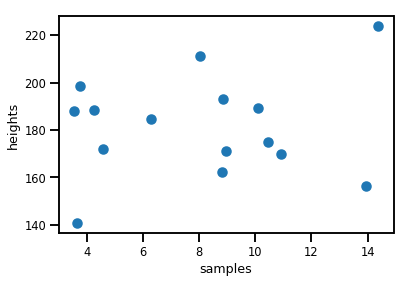

In [0]:
# Observed data
n = 15
true_mu = 178.
true_sigma = 20.

x = np.random.uniform(1, 15, n)
true_y = true_mu + np.random.normal(0., true_sigma, n)

# Visualize the data set
plt.scatter(x, true_y )
plt.xlabel("samples")
plt.ylabel("heights")

### Build the unnormalized posterior

In [0]:
# Calculate the likelihood
likelihood = tfd.Normal(loc=true_mu, scale=true_sigma).log_prob

# According to bayes theorm, using likelihood represent unnormalized posterior
posterior = likelihood

### Sampling the posterior using Hamiltonian Monte Carlo method

In [0]:
# Sampling the posterior
states = tfp.mcmc.sample_chain(
    num_results = 10000,
    num_burnin_steps = 500,
    current_state = tf.zeros(1),
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn = likelihood,
      step_size = 0.5,
      num_leapfrog_steps = 2),
    trace_fn=None)

sampled_posterior = states

W0805 22:22:18.127178 140676690061184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Trace the result

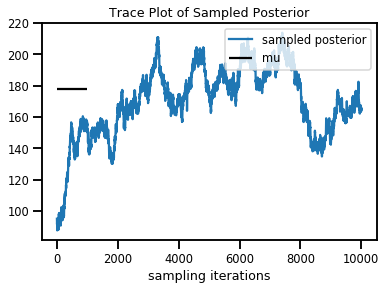

In [0]:
# Tracing sampled posterior
plt.title('Trace Plot of Sampled Posterior')
plt.plot(sampled_posterior, label='sampled posterior')
plt.hlines(true_mu, 0, 1000, zorder=4, label="mu")
plt.legend(loc='upper right')
plt.xlabel("sampling iterations")
plt.show()

### Estimating mu and sigma

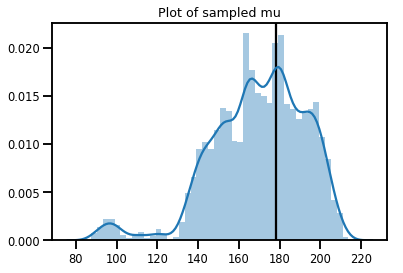

The value of sampled mu: tf.Tensor([169.61717], shape=(1,), dtype=float32)


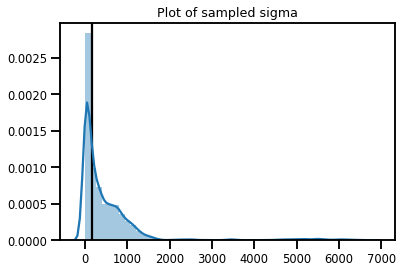

The value of sampled sigma: tf.Tensor([22.988361], shape=(1,), dtype=float32)


In [0]:
# Plotting sampled mu
plt.title('Plot of sampled mu')
sns.distplot(sampled_posterior)
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

# Calculating sampled mu
sampled_mu = tf.reduce_mean(sampled_posterior, axis=0)
print("The value of sampled mu:", sampled_mu)

# Plotting sampled sigma
plt.title('Plot of sampled sigma')
sns.distplot(tf.math.squared_difference(sampled_posterior, sampled_mu))
ymax = plt.ylim()[1]
plt.vlines(true_mu, 0, ymax)
plt.ylim(0, ymax)
plt.show()

# Calculating sampled sigma
sampled_sigma = tf.sqrt(tf.reduce_mean(
    tf.math.squared_difference(sampled_posterior, sampled_mu),
    axis=0))
print("The value of sampled sigma:", sampled_sigma)

## Markov Chain Analysis

We describe a Markov chain as follows: We have a set of states, X = {$x_1$, $x_2$,...,$x_n$}.The process starts in one of these states and moves successively from one state to another. Each move is called a step. If the chain is currently in state $x_t$, then it moves to state $x_{t+1}$ at the next step with a probability denoted by $p(x_{t+1}|x_t)$ which is called **Transition probability**, and this probability does not depend upon which states the chain was in before the current state.

Mathematically, $$p(X_{t+1}|X_t,X_{t−1}, \ldots ,X_2,X_1)=p(X_{t+1}|X_t)$$

**Example 1:** $\tag{2}$
<br>
For 3 discrete states shown below, there are transition probabilities to
move to other states, as well as a probability to stay in the
same state.
![hier4](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.1/hier-4.PNG)
<br>
$$\ p(A \rightarrow A)=0.7\ \ \ \ \ \ \ p(A \rightarrow B)=0.3\ \ \ \ p(A \rightarrow C)=0.0$$
<br>
$$\ \ p(B \rightarrow A)=0.15\ \ \ \ \ p(B \rightarrow B)=0.6\ \ \ \ p(B \rightarrow C)=0.25$$
<br>
$$p(C \rightarrow A)=0.1\ \ \ \ \ \ \ p(C \rightarrow B)=0.3\ \ \ \ p(C \rightarrow C)=0.6$$

<br>
<br>
Transition probability matrix can be written as,
$P = $
$\begin{bmatrix} 
0.7 & 0.3 & 0.0 \\ 
0.15 & 0.6 & 0.25 \\ 
0.1 & 0.3 & 0.6  
\end{bmatrix}$

Now, let us assume at time n the system is in state 2 = B, then 3 time periods later at time n+3 the distribution is,
<br>

$$x^{(n+3)} = x^{(n+2)}P$$
<br>
$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = (\ x^{(n+1)}P\ )P$$
<br>
$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = (\ x^{(n)}P\ )P^2$$
<br>
$$ \ \ \ \ \ \ = x^n P^3$$
$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = \begin{bmatrix} 
0 & 1 & 0 
\end{bmatrix}
\begin{bmatrix} 
0.7 & 0.3 & 0.0 \\ 
0.15 & 0.6 & 0.25 \\ 
0.1 & 0.3 & 0.6  
\end{bmatrix}^3
$$

$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = \begin{bmatrix} 
0 & 1 & 0 
\end{bmatrix}
\begin{bmatrix} 
0.4405 & 0.417 & 0.1425 \\ 
0.256 & 0.444 & 0.3 \\ 
0.2245 & 0.417 & 0.3585  
\end{bmatrix}
$$

$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = \begin{bmatrix} 
0.256 & 0.444 & 0.3 
\end{bmatrix}
$$

**Example 2:** $\tag{2}$
<br>
• Let’s make a simulation of a chain with two different starting points; one change starting at 100 and another at -27.
<br>
• The step to $X_{t+1}$ from $X_t$ is governed by a random number drawn from a normalized gaussian PDF (scipy.stats.norm()) that is dependent on $X_t$
<br>
• The PDF is of the form: $$ \frac {1}{{\sigma}\sqrt{2\pi}}e^{- \left(\frac{({x- 0.5X_t})^{2}}{2{\sigma}^{2}}\right)}\ \ \ \ \ \ \ \ \ \ \sigma = 1 $$

• Plot the values versus the iteration number. The point here is to see the Markov chain converge to a stationary
distribution.
<br>
• After maybe 5-10 iterations from the starting point the chains look to converge to some stationary behavior.
<br>
![hier5](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.1/hier-5.PNG)
<br>
• The samples before convergence are commonly known as ‘burn-in samples’ and are not often included when estimating the posterior distribution. They’re generally just discarded and understood as the cost of using Markov Chain Monte Carlos.
<br>
• Assuming that the distribution that this chain converges to is a gaussian, use the samples after some number of iterations (~10) to estimate the mean and sigma.
<br>
![hier6](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.1/hier-6.PNG)
<br>
<br>
  

### MCMC:
With MCMC, samples are drawn from a proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). Under certain conditions, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that ensure that the stationary distribution is the posterior distribution of interest [3]. 
<br>
<br>
While there are many MCMC methods available, its two common variants namely Metropolis-Hastings and Gibbs samplers are described below.


### 1. Metropolis-Hastings:

Let us assume $X$ is moving from its current state to the next state i.e. $X \rightarrow X^|$
<br>
Now we can write, $$p(X)p(X \rightarrow X^|) = p(X^|)p(X^| \rightarrow X)$$
<br>
$$\frac{p(X \rightarrow X^|)}{p(X^| \rightarrow X)} = \frac{p(X^|)}{p(X)}\tag{eq.1}$$
<br>

Now $p(X \rightarrow X^|)$ can be written as $$p(X \rightarrow X^|) = g(X \rightarrow X^|)\ a(X \rightarrow X^|)$$
<br>
Similarily, $$p(X^| \rightarrow X) = g(X^| \rightarrow X)\ a(X^| \rightarrow X)$$
<br>
Where $g(X)$ is the **Proposal distribution** and $a(X)$ is the ** Acceptance distribution**.

Now the **acceptance ratio** ($\normalsize\rho$) can be written as:
<br>
<br>
<br>
$$ \normalsize\rho = \frac{a(X \rightarrow X^|)}{a(X^| \rightarrow X)} = \frac{p(X^|)g(X^| \rightarrow X)}{p(X)g(X \rightarrow X^|)} = \frac{p(X^|)g(X | X^|)}{p(X)g(X^|| X)}$$

<br>

We move from $X \rightarrow X^|$ conditionally based on the value of $\large\rho$.
<br>
• If  $\ \large\rho\normalsize\geq$ 1, move from $X \rightarrow X^|$ is transition to a more equally likely state and it should be accepted i.e. $X_{t+1} = X^|$
<br>
• If  $\ \large\rho\normalsize<$ 1, move from $X \rightarrow X^|$ is rejected i.e. $X_{t+1} = X$

<br>
### 2. Giibs Sampling:
$\tag{3}$

Suppose we have a vector of parameters $\theta=(\theta_1,\theta_2, \ldots ,\theta_k)$, and we want to estimate the joint posterior distribution $p(\theta|X)$. Suppose we can find and draw random samples from all the conditional distributions

$$p(\theta_1 | \theta_2, \dots \theta_k, X) \\ p(\theta_2 | \theta_1, \dots \theta_k, X) \\ \dots \\ p(\theta_k | \theta_1, \theta_2, \dots, X)$$
<br>
Gibbs sampling involves the sampling from the conditional distribution for each parameter $θ_i$ to construct a Markov Chain in turn, treating all other parameters as observed. Iterating over all parameters once is considered to have completed one cycle of the Gibbs sampler. Typically, Hierarchical models are set up as products of conditional distributions, which makes the Gibbs sampler ubiquitous in Bayesian modeling. Metropolis-Hastings algorithm can be used instead Gibbs wherein sampling is difficult from conditional distribution - this is known as Metropolis within Gibbs.

With Gibbs sampling, We draw a proposal for a new value of a particular parameter at each iteration in the cycle, where the proposal distribution is the conditional posterior probability of that parameter. This means that the proposal move is always accepted. Hence, if we can draw samples from the conditional distributions, Gibbs sampling can be much more efficient than regular Metropolis-Hastings. More formally, we want to show that

$$\frac{P(y) \, q(y \to x)}{P(x) \, q(x \to y)} = 1$$


**Advantages:**

• No tuning is required to proposal distribution
<br>
• Proposals are always accepted

**Disadvantages:**

• Need to be able to derive conditional probability distributions
<br>
• Need to be able to draw random samples from the derived conditional probability distributions
<br>
• If parameters are correlated, it can be very slow

**Example:**
We’ll repeat the example of determining the bias of a coin from observed coin tosses. The likelihood is binomial, and we use a beta prior.

## Metropolis Sampling

### Build the model

In [0]:
# Observed data
n = 100
h = 61.
alpha = 2.
beta = 2.

# define priors
p = np.random.beta(alpha, beta)

# define likelihood
y = tfd.Binomial(total_count=n, probs=p)
rv_y = y.log_prob

### Sampling the model

In [0]:
# Sampling likelihood
states = tfp.mcmc.sample_chain(
    num_results = 10000,
    num_burnin_steps = 500,
    current_state = tf.zeros(1),
    kernel = tfp.mcmc.MetropolisHastings(
    tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
        target_log_prob_fn = rv_y,
        step_size = 0.1,
        num_leapfrog_steps = 3)),
    trace_fn = None)

 ### Trace the result

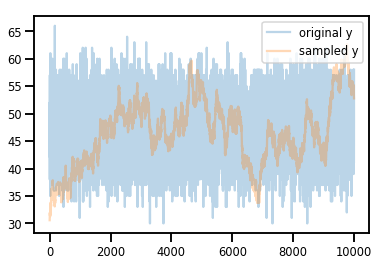

In [19]:
# Compare original value and sampled value
original_y = y.sample(10000)
sampled_y = states

# Trace plots
plt.plot(original_y, alpha=.3, label="original y")
plt.plot(sampled_y, alpha=.3, label="sampled y")
plt.legend(loc='upper right')
plt.show()

## References

[1] Bayesian Statistics: Techniques and Models - Week1 ,2018.[Online].Available: https://www.coursera.org/learn/mcmc-bayesian-statistics/home/welcome
<br>
[2] D. Jason Koskinen,"Markov Chain Monte Carlo",Feb 2018.[Online].Available:http://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2018/Lecture6_MCMC_Bayes.pdf
<br>
[3] Computational Statistics in Python,"Markov Chain Monte Carlo (MCMC)",[Online].Available: https://people.duke.edu/. 
<br>
[4] Tensorflow Statistical Distributions, [Online].Available: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions. 
<br>
[5] TensorFlow Probability MCMC python package, [Online].Available: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc. 